In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("../../analysisTools")
import plotTools as ptools
import mplhep

## Combine

### output root files

In [2]:
base="/uscms/home/kyungmip/nobackup/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/SR_CutBased_Jan2024/"

In [3]:
import os
import uproot
import pandas as pd
xs = pd.read_csv('/uscms/home/sbrightt/nobackup/iDMe/signal_xsec/MG5_aMC_v2_9_6/bin/signal_xsec_table.csv')
xs = xs[xs.alphaD=="aEM"]
xs['m1'] = xs.Mchi - xs.dMchi/2
xs['delta'] = xs.dMchi/xs.m1

In [4]:
#cut_setting = f"dPhiCut{xlim:.1f}_dxyCut{ylim:.2f}".replace(".","p")
cut_setting = 'Cut'
root_files = [f for f in os.listdir(base) if '.root' in f and cut_setting in f]

root_files

['higgsCombine.0p2_10_1_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_30_1_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_50_1_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_10_10_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_20_10_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_40_10_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_5_10_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_5_100_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_20_100_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_40_100_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p2_50_100_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p1_10_1_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p1_20_1_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p1_30_1_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p1_40_1_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p1_50_1_Cut.AsymptoticLimits.mH120.root',
 'higgsCombine.0p1_5_1_Cut.AsymptoticLimits.mH120.root',
 'hig

In [5]:
m1s = []
cts = []
deltas = []
rs = []
rs_plus1 = []
rs_minus1 = []
rs_plus2 = []
rs_minus2 = []
xsecs = []

for rf in root_files:
    point = rf.split('.')[1]
    delta,m1,ct,SR = point.split("_")
    delta = float(delta.replace("p","."))
    m1 = float(m1.replace("p","."))
    ct = float(ct.replace("p","."))
    xsecs.append(xs[(xs.m1==m1)&(xs.delta==delta)&(xs.ct==ct)]['xsec(pb)'].iloc[0])
    deltas.append(delta)
    m1s.append(m1)
    cts.append(ct)
    with uproot.open(base+rf)['limit'] as rootf:
        lims = rootf['limit'].array().to_numpy()
    rs_minus2.append(lims[0])
    rs_minus1.append(lims[1])
    rs.append(lims[2])
    rs_plus1.append(lims[3])
    rs_plus2.append(lims[4])

lims = pd.DataFrame({
    "m1":m1s,
    "ct":cts,
    "delta":deltas,
    "r":rs,
    "rp1":rs_plus1,
    "rm1":rs_minus1,
    "rp2":rs_plus2,
    "rm2":rs_minus2,
    "xsec":xsecs
})

## Plot

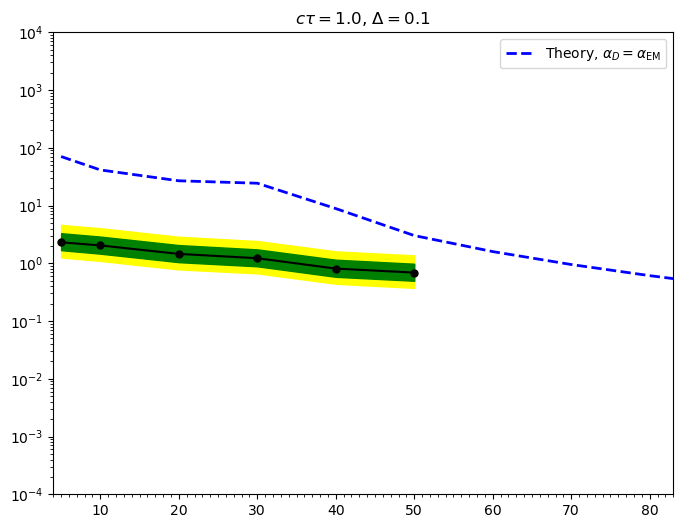

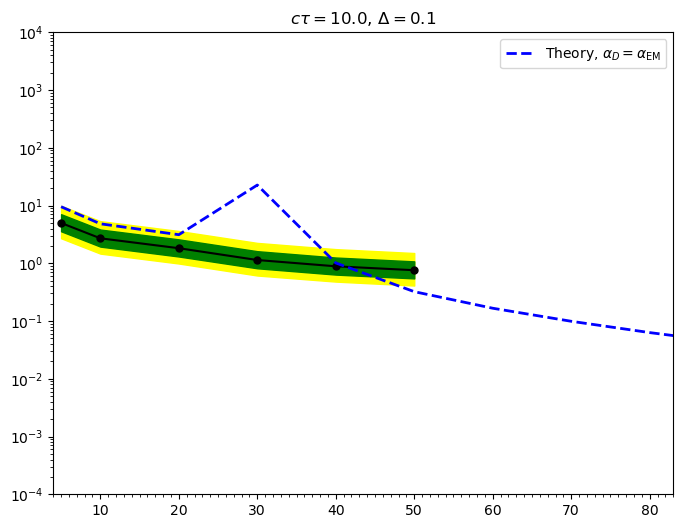

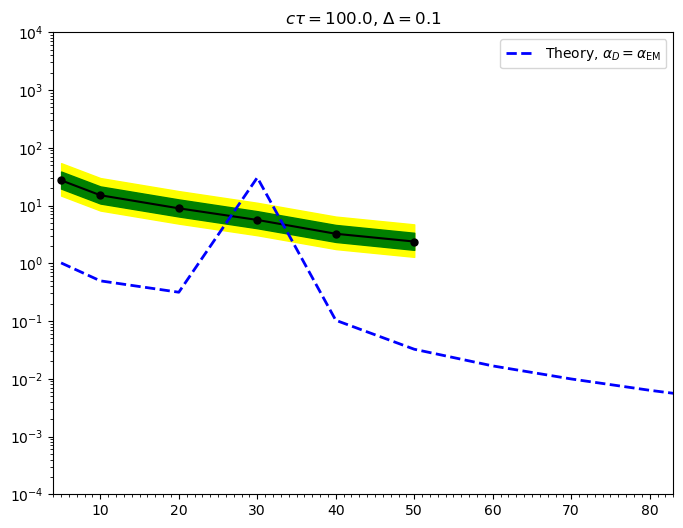

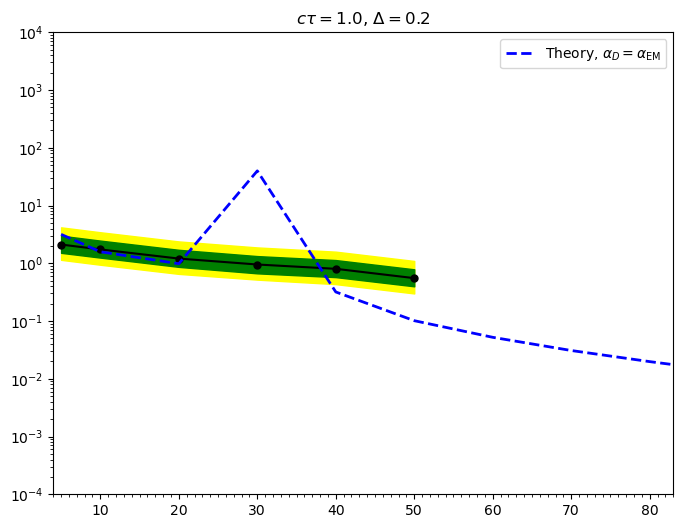

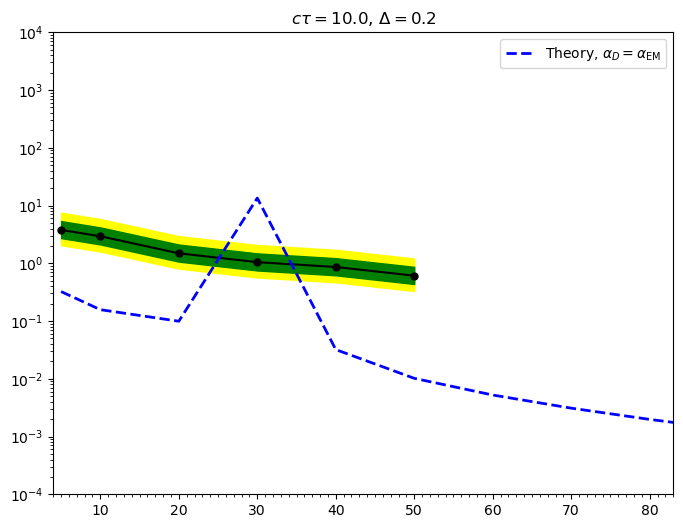

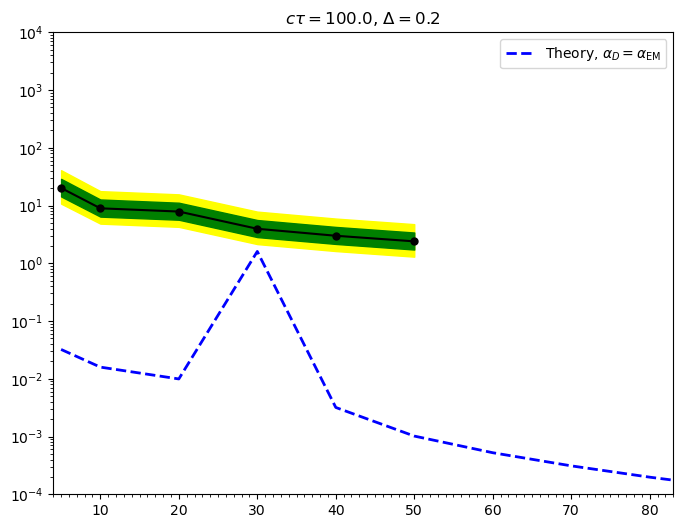

In [6]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

deltas = sorted(list(set(lims.delta)))
all_ctaus = sorted(list(set(lims.ct)))
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        mass1s = sorted(list(set(lims[(lims.delta==d)&(lims.ct==ct)].m1.array.to_numpy())))
        noms = []
        p1s = []
        m1s = []
        p2s = []
        m2s = []
        theory_xsec = xs[(xs.delta==d)&(xs.ct==ct)]["xsec(pb)"].array.to_numpy()
        theory_m1 = xs[(xs.delta==d)&(xs.ct==ct)]["m1"].array.to_numpy()
        srt = np.argsort(theory_m1)
        theory_m1 = theory_m1[srt]
        theory_xsec = theory_xsec[srt]
        for m1 in mass1s:
            r = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].r.iloc[0]
            rm1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm1.iloc[0]
            rp1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp1.iloc[0]
            rm2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm2.iloc[0]
            rp2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp2.iloc[0]
            xsec = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].xsec.iloc[0]
            noms.append(r*xsec)
            m1s.append(rm1*xsec)
            p1s.append(rp1*xsec)
            m2s.append(rm2*xsec)
            p2s.append(rp2*xsec)
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        plt.fill_between(mass1s,m2s,p2s,color="yellow")
        plt.fill_between(mass1s,m1s,p1s,color="green")
        plt.plot(mass1s,noms,color="black",marker=".",markersize=10)
        plt.plot(theory_m1,theory_xsec,color="blue",linestyle="--",linewidth=2,label=r"Theory, $\alpha_D = \alpha_\mathrm{EM}$")
        plt.legend()
        plt.ylim([1e-4,1e4])
        plt.yscale('log')
        plt.xlim([4,83])
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        
        plt.savefig(f"limit_cut-based_delta{d}_ct{ct}.png")